# Univariate HP with Exponential Decay

In this notebook, we present an example use case of fitting (calibrating) and sampling from a univariate Hawkes (self-exciting) process with exponential delay density. Concretely, the HP is determined by the conditional intensity function

$$
\begin{align}
\lambda^*(t) &= \mu + \alpha \sum_{t_j < t} g_\theta(t - t_j) \\
g_\theta(x) &= -\theta \exp (-\theta x )
\end{align}
$$

In [1]:
import sys

sys.path.append("/home/caner/code/hawkes_bound/")

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from fasthawkes.model.uv_exp import UnivariateExpHawkesProcess as UVHP

## Example 1: FX Price Jump Data

Fit to real data and get Monte Carlo estimates of the distribution of number of occurrences via Ogata's modified thinning method.

In [3]:
df = pd.read_csv("example_data.csv", header=None)
df.columns = ["mark", "time"]

In [4]:
# take all mark 21 and fit a univariate exp HP
td = np.array(df.loc[df.mark == 21, :].get("time")).astype(np.float64)

proc = UVHP()
proc.fit(td, method="em")

-58566.648221072

In [5]:
# verify that the unconditional mean makes sense
mu, alpha, theta = proc.get_params()

N_approx = mu * td[-1] / (1 - alpha)

print(N_approx)
print(len(td))

8005.413329839444
8003


In [6]:
%%time
# take unconditioned samples from this HP, and estimate the distribution of 
# number of occurrences in a ten second period

counts = []
for j in range(100000):
    n = len(proc.sample(T=10000))  # time in millis
    counts.append(n)

CPU times: user 9.64 s, sys: 97.4 ms, total: 9.74 s
Wall time: 2.54 s


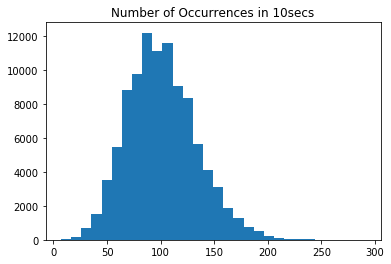

In [7]:
plt.title("Number of Occurrences in 10secs")
plt.hist(counts, bins=30)
plt.show()

## Example 2: Simulated Data

We simulate HPs and try to fit their parameters.

In [3]:
param_pairs = []
for j in range(100):
    # priors
    pars = np.random.gamma(3.), np.random.rand() * .3, np.random.gamma(5.)
#     print j
    hp = UVHP()
    hp.set_params(*pars)
    smp = hp.sample(100000,method="branching")
    
    # fit with gd
    hp2 = UVHP()
    hp2.fit(smp, method="gd")
    
    # fit with em
    hp3 = UVHP()
    hp3.fit(smp, method="em", reltol=1e-6)
    
    comb_pars = hp.get_params() + hp2.get_params() + hp3.get_params()
    param_pairs.append(comb_pars)
#     print param_pairs
    print ["%0.4f" % i for i in comb_pars]

['2.2883', '0.0599', '3.0312', '2.2843', '0.0613', '2.9789', '2.2439', '0.0779', '1.8665']
['2.0299', '0.1767', '6.3121', '2.0446', '0.1723', '6.3315', '2.0418', '0.1734', '6.2556']
['6.0940', '0.2380', '2.6440', '6.1106', '0.2344', '2.5964', '5.9028', '0.2605', '2.1308']
['6.4008', '0.1533', '4.6891', '6.3938', '0.1548', '4.6746', '6.2453', '0.1745', '3.7427']
['4.3933', '0.1155', '3.5713', '4.4018', '0.1161', '3.5383', '4.3125', '0.1341', '2.7069']


KeyboardInterrupt: 

[]

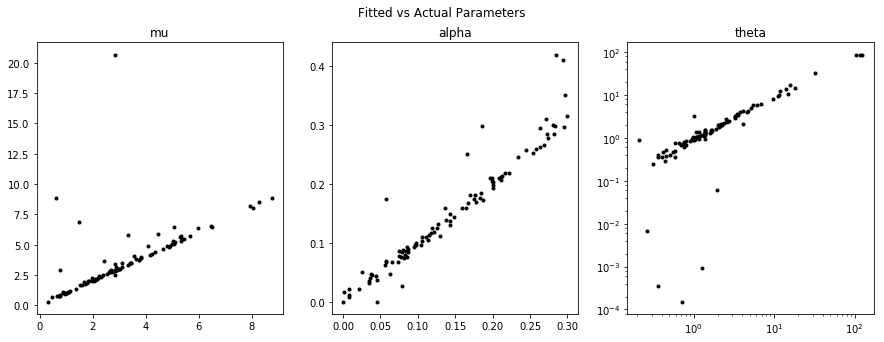

In [11]:
Z = np.array(param_pairs)

f, ax = plt.subplots(1, 3, figsize=(15,5))
f.suptitle("Fitted vs Actual Parameters")
for k in range(3):
    ax[k].plot(Z[:, k], Z[:, k+3], "k.")
    ax[k].set_title(["mu", "alpha", "theta"][k])

ax[2].loglog()


In [44]:
# check the outlier

df_pars = pd.DataFrame(Z)

print df_pars[df_pars[3] > 30]  # very high theta!

           0         1           2          3         4           5
31  3.689706  0.230092  368.904952  40.976832  0.357055  263.923984
